In [1]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

In [2]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IYKQQP_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IYKQQP_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.IYKQQP_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_e

In [4]:
train_data, test_data = imdb['train'], imdb['test']

In [5]:
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

for s, l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s, l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

In [6]:
training_sentences[3], training_labels[3]

("b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.'",
 np.int64(1))

In [7]:
len(training_sentences), len(training_labels)

(25000, 25000)

In [8]:
len(testing_labels), len(testing_sentences)

(25000, 25000)

In [9]:
testing_labels = np.array(testing_labels)
training_labels = np.array(training_labels)

Preprocessing

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
tokenizer = Tokenizer(num_words=10000) # most frequent top 10 words will be considered

the b was causing problem. b'xyz' is stored as bytes. So, used str() to cast it as "b'xyz'"

In [12]:
tokenizer.fit_on_texts(training_sentences)

In [13]:
word_index = tokenizer.word_index

In [14]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=500, truncating='post', padding='post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=500, truncating='post', padding='post')

In [15]:
padded.shape, testing_padded.shape

((25000, 500), (25000, 500))

Build the model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, GRU, SimpleRNN

1) SimpleRNN

In [17]:
model_rnn = Sequential([
    Embedding(10000, 50, input_length=500), # vocab size, embedding dimensions, input length
    SimpleRNN(32), # default activation tanh
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # output


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
hist = model_rnn.fit(padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.5025 - loss: 0.6939 - val_accuracy: 0.5035 - val_loss: 0.6933
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5150 - loss: 0.6925 - val_accuracy: 0.5060 - val_loss: 0.6931
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.5038 - val_loss: 0.6931
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5050 - loss: 0.6929 - val_accuracy: 0.5055 - val_loss: 0.6933
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5053 - loss: 0.6927 - val_accuracy: 0.5057 - val_loss: 0.6931
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5194 - loss: 0.6918 - val_accuracy: 0.5046 - val_loss: 0.6944
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5235 - loss: 0.6904 - val_accuracy: 0.4930 - val_loss: 0.6935
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5214 - loss: 0.6868 - 

In [22]:
import pandas as pd

hist_df = pd.DataFrame(hist.history)

<Axes: >

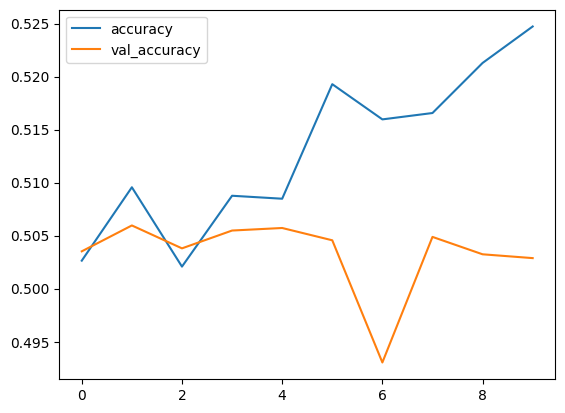

In [23]:
hist_df.plot(y=['accuracy', 'val_accuracy'])

<Axes: >

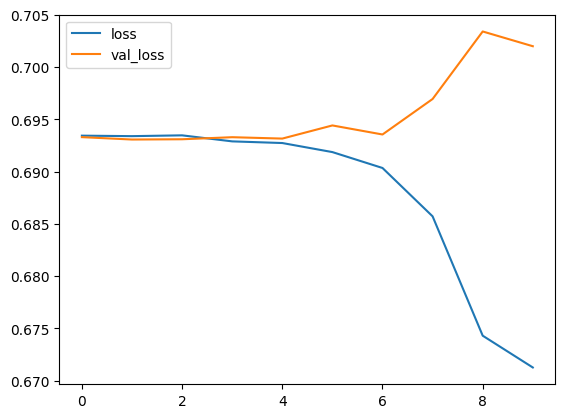

In [24]:
hist_df.plot(y=['loss', 'val_loss'])

In [29]:
model_lstm = Sequential([
    Embedding(10000, 50, input_length=500), # vocab size, embedding dimensions, input length
    LSTM(32), # default activation tanh
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # output


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
hist_lstm = model_lstm.fit(padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.4970 - loss: 0.6931 - val_accuracy: 0.5092 - val_loss: 0.6912
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5184 - loss: 0.6846 - val_accuracy: 0.5124 - val_loss: 0.6896
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.5128 - loss: 0.6916 - val_accuracy: 0.5068 - val_loss: 0.7075
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5314 - loss: 0.6612 - val_accuracy: 0.5112 - val_loss: 0.7003
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5405 - loss: 0.6503 - val_accuracy: 0.5108 - val_loss: 0.7176
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6227 - loss: 0.6039 - val_accuracy: 0.8142 - val_loss: 0.4421
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8752 - loss: 0.3257 - val_accuracy: 0.8328 - val_loss: 0.4073
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9120 - loss: 0.2404 - 

<Axes: >

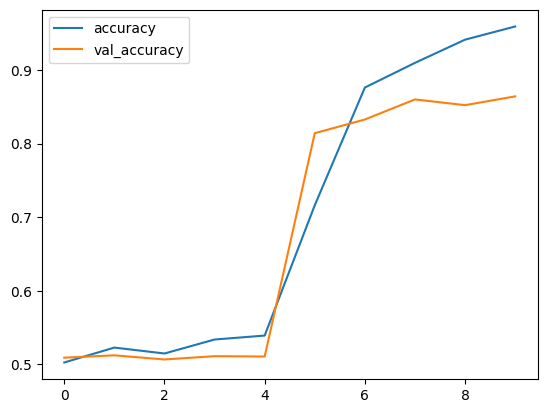

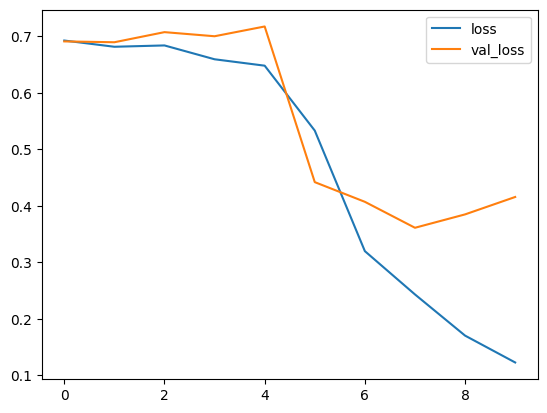

In [32]:
hist_lstm_df = pd.DataFrame(hist_lstm.history)
hist_lstm_df.plot(y=['accuracy', 'val_accuracy'])
hist_lstm_df.plot(y=['loss', 'val_loss'])

In [33]:
model_gru = Sequential([
    Embedding(10000, 50, input_length=500), # vocab size, embedding dimensions, input length
    GRU(32), # default activation tanh
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # output


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
hist_gru = model_gru.fit(padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.5063 - loss: 0.6932 - val_accuracy: 0.5048 - val_loss: 0.6929
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5210 - loss: 0.6882 - val_accuracy: 0.5069 - val_loss: 0.6963
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5267 - loss: 0.6743 - val_accuracy: 0.5075 - val_loss: 0.7070
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5383 - loss: 0.6538 - val_accuracy: 0.5084 - val_loss: 0.7255
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5310 - loss: 0.6440 - val_accuracy: 0.5069 - val_loss: 0.7512
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5428 - loss: 0.6426 - val_accuracy: 0.7150 - val_loss: 0.6710
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.8087 - loss: 0.4955 - val_accuracy: 0.8747 - val_loss: 0.3163
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9293 - loss: 0.1913 - 

<Axes: >

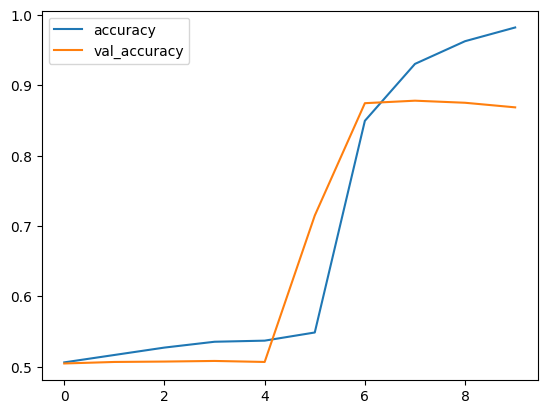

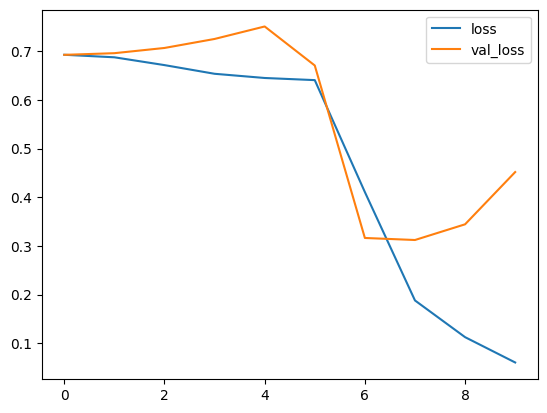

In [36]:
hist_gru_df = pd.DataFrame(hist_gru.history)
hist_gru_df.plot(y=['accuracy', 'val_accuracy'])
hist_gru_df.plot(y=['loss', 'val_loss'])

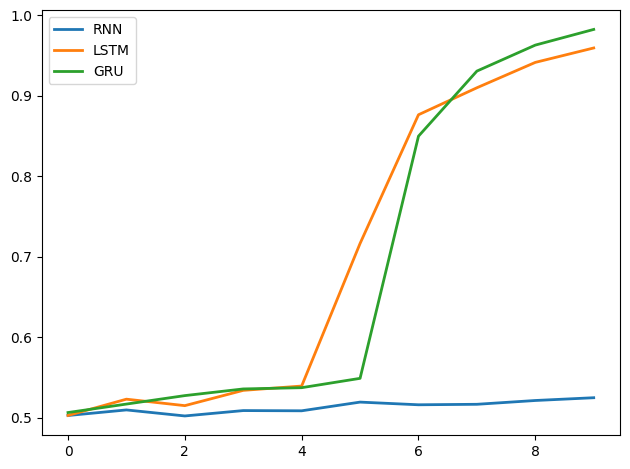

In [42]:
#  accuracy comparison
import matplotlib.pyplot as plt

plt.plot(hist_df['accuracy'], label='RNN', lw=2)
plt.plot(hist_lstm_df['accuracy'], label='LSTM', lw=2)
plt.plot(hist_gru_df['accuracy'], label='GRU', lw=2)
plt.legend()
plt.tight_layout()

In [54]:
# prediction
def predict_new(text):
  sequences = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(sequences, maxlen=500, truncating='post', padding='post')

  pred_rnn = model_rnn.predict(padded, verbose=0)
  if pred_rnn > 0.5:
    print('RNN --- Positive', pred_rnn[0][0])
  else:
    print('RNN --- Negative', pred_rnn[0][0])

  pred_lstm = model_lstm.predict(padded, verbose=0)
  if pred_lstm > 0.5:
    print('LSTM --- Positive', pred_lstm[0][0])
  else:
    print('LSTM --- Negative', pred_lstm[0][0])

  pred_gru = model_rnn.predict(padded, verbose=0)
  if pred_gru > 0.5:
    print('GRU --- Positive', pred_gru[0][0])
  else:
    print('GRU --- Negative', pred_gru[0][0])

  return

In [55]:
new1 = 'This was worst movie. Please do not watch it. WAste of money and time.'
new2 = 'A must watch movie. I lived to watch it. It was just amazing.'

In [57]:
predict_new(new2)

RNN --- Negative 0.4940941
LSTM --- Positive 0.8348585
GRU --- Negative 0.4940941
